In [1]:
import sys
import scipy.io
import h5py
import numpy as np
from os.path import join as oj
import matplotlib.pyplot as plt
# %matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
import pandas as pd
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path

from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import decomposition
import matplotlib.gridspec as grd
from sklearn import neural_network

from data_load_process import data
from data_load_process import preprocess

%load_ext autoreload
%autoreload 2

# load data

In [2]:
# data params
resp_file = oj(data.V4_dset.v4_dir, 'v1v2_pop', 'zc1_33_10_data_multi.mat') # zc1_12_8_data_multi.mat  zc1_29_9_data_multi.mat   zc1_33_10_data_multi.mat zc1_28_8_data_multi.mat  zc1_31_10_data_multi.mat  zc1_81_9_data_multi.mat
folder_nums = range(0, 1)

dset = data.V4_dset(resp_file=resp_file, train_or_test='train', folder_nums=folder_nums)
folders = dset.get_stim_folders_for_population(resp_file) # names of folders
resps = dset.get_resps_for_population(resp_file, folder_nums) # neurons x timepoints
resps_norm = preprocess.normalize_resps(resps)

dset_val = data.V4_dset(resp_file=resp_file, train_or_test='test') 
resps_test = dset_val.get_resps_for_population(resp_file, folder_nums) # neurons x timepoints

# view some responses

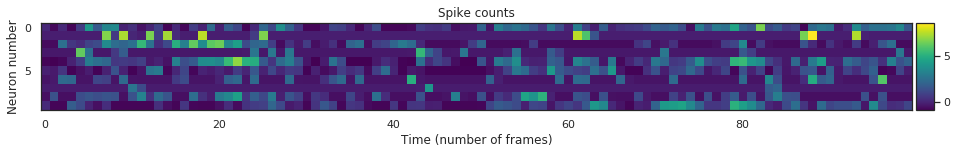

In [3]:
tstart = 0
tend = 100

plt.figure(figsize=(16, 9))
ax = plt.gca()
p = plt.imshow(resps_norm[:, tstart: tend], interpolation='None', cmap='viridis')
plt.xlabel('Time (number of frames)')
plt.ylabel('Neuron number')
plt.title('Spike counts')

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
plt.colorbar(p, cax=cax)

plt.show()

**view time lagged corrs**

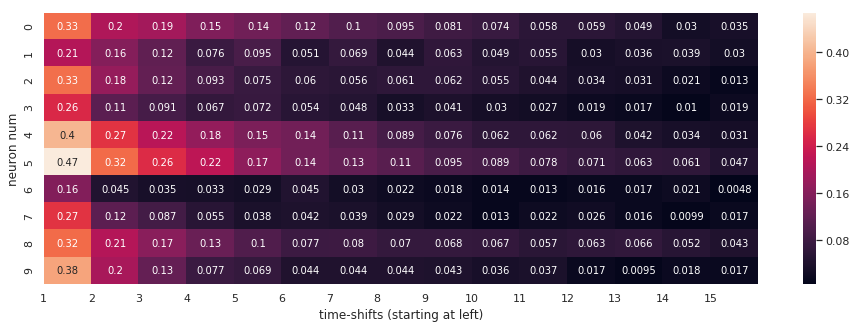

In [5]:
r = resps_norm.copy()
plt.figure(figsize=(16, 5))
num_shifts = 15 # number of shifts
shift_spacing = 1 # spacing between each shift
corrs_shifted = np.zeros((10, num_shifts))
shifts = np.arange(1, num_shifts * shift_spacing + 1, shift_spacing)
for i, shift in enumerate(shifts):
    orig = r[:, :-shift] # neurons x orig
    shifted = r[:, shift:].copy()
    corrs = np.mean(np.multiply(orig, shifted), axis=1) # elementwise multiply
    corrs = corrs / np.std(orig, axis=1) / np.std(shifted, axis=1)
    corrs_shifted[:, i] = corrs.flatten().copy()
# plt.imshow(corrs_shifted)
sns.heatmap(corrs_shifted, annot=True)
plt.ylabel('neuron num')
plt.xlabel('time-shifts (starting at left)')
plt.xticks(ticks=range(shifts.size), labels=shifts)
plt.show()

# look at pcs

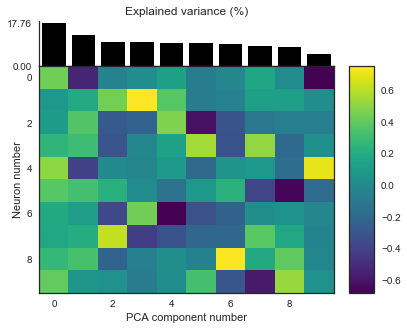

In [35]:
def plot_pcs(pca, comps):

    # create a 2 X 2 grid 
    gs = grd.GridSpec(2, 2, height_ratios=[2,10], 
                      width_ratios=[12, 1], wspace=0.1, hspace=0)

    try:
        var_norm = pca.explained_variance_ / np.sum(pca.explained_variance_) * 100
        # plot explained variance
        ax2 = plt.subplot(gs[0])
        ax2.bar(np.arange(0, comps.shape[1]), var_norm, 
                color='black', width=0.8)
        plt.title('Explained variance (%)')
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
#         ax2.xaxis.set_visible(False)
        ax2.yaxis.set_ticks_position('left')
        ax2.set_yticks([0, max(var_norm)])
        plt.xlim((-0.5, comps.shape[1]-0.5))
    except:
        print('not pca')

    # plot pcs
    
    ax = plt.subplot(gs[2])
    p = ax.imshow(comps, interpolation='None', cmap='viridis',aspect='auto')
    plt.ylabel('Neuron number')
    plt.xlabel('PCA component number')

    # make colorbar
    colorAx = plt.subplot(gs[3])
    cb = plt.colorbar(p, cax = colorAx)

    plt.show()
    

# perform pca
pca = decomposition.PCA()
# pca = decomposition.NMF()
pca.fit(resps_norm.transpose())
comps = pca.components_.transpose()
plt.figure(figsize=(6, 5))
plot_pcs(pca, comps)

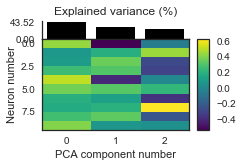

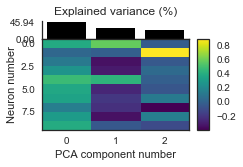

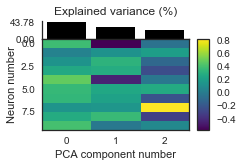

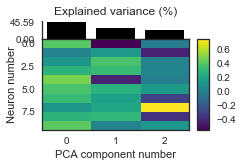

In [38]:
# pcs are fairly consistent over folders
for folder_num in range(4):
    resps = dset.get_resps_for_population(resp_file, folder_nums=[folder_num])
    resps_norm = preprocess.normalize_resps(resps)
    # perform pca
    pca = decomposition.PCA(n_components=3)
    # pca = decomposition.NMF()
    pca.fit(resps_norm.transpose())
    comps = pca.components_.transpose()
    plt.figure(figsize=(3, 2))
    plot_pcs(pca, comps)

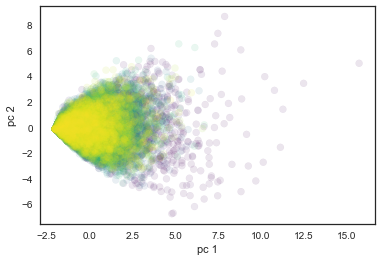

In [6]:
# plot the points in pc space
pca = decomposition.PCA(n_components=2)
# pca = decomposition.NMF()
resps_reduced = pca.fit_transform(resps_norm.transpose())
plt.scatter(resps_reduced[:, 0], resps_reduced[:, 1], 
            c=np.arange(20000), cmap='viridis', alpha=0.1)
plt.xlabel('pc 1')
plt.ylabel('pc 2')
plt.show()

# plot in 3d
# pca = decomposition.PCA(n_components=3)
# pca = decomposition.NMF()
# resps_reduced = pca.fit_transform(resps_norm.transpose())
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(resps_reduced[:, 0], resps_reduced[:, 1], 
#            resps_reduced[:, 2], alpha=0.1, c=np.arange(20000), cmap='viridis')
plt.show()

# compare correlations

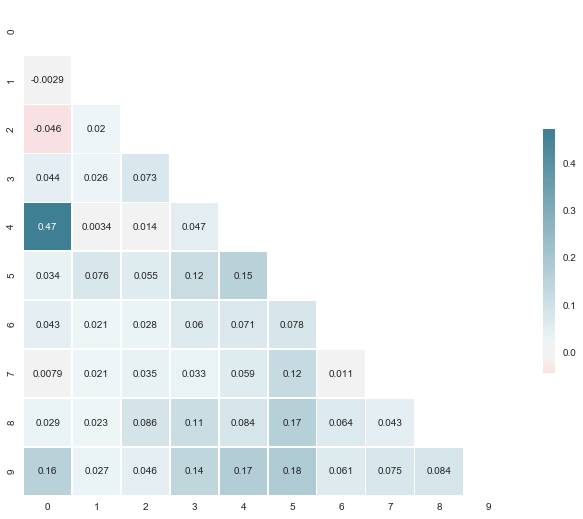

In [25]:
# clean correlations
# cors = np.corrcoef(resps)
# num_neurons = cors.shape[0]
# for r in range(num_neurons):
#     for c in range(r, num_neurons):
#         cors[r, c] = np.nan
    
# plt.imshow(cors, interpolation='None', cmap='viridis')
# plt.colorbar()
# plt.show()

cors = np.corrcoef(resps)


'''
num_neurons = cors.shape[0]
mask = np.zeros(shape=cors.shape)
for r in range(num_neurons):
    for c in range(r, num_neurons):
        mask[r, c] = 1
mask = np.eye(num_neurons)  
vmax = np.max(cors[mask!=1])
vmin = np.min(cors[mask!=1])
    
cors[mask==1] = 0
sns.clustermap(cors, cmap="viridis",
               linewidths=.75, figsize=(13, 13), 
               vmax=vmax, vmin=vmin, annot=True)
'''

# Generate a mask for the upper triangle
mask = np.zeros_like(cors, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(cors, mask=mask, cmap=cmap, vmax=np.max(cors[mask==0]), center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# histogram neural responses

/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


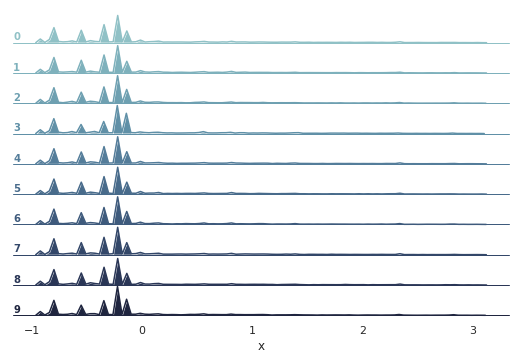

In [62]:
def joyplot(resps):
    num_neurons = resps.shape[0]
    # Create the data
    x = np.squeeze(resps.reshape(-1, 1))
    x[x>3.1] = 0
    g = np.tile(list(str(x) for x in range(num_neurons)), 20000)
    df = pd.DataFrame(dict(x=x, g=g))

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, bw=.01)
    g.map(plt.axhline, y=0, lw=1, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color, 
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "x")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-0) #.25)

    # Remove axes details that don't play will with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    

    plt.show()
    
# joyplot(resps)
joyplot(resps_norm)

# compare neurons against each other

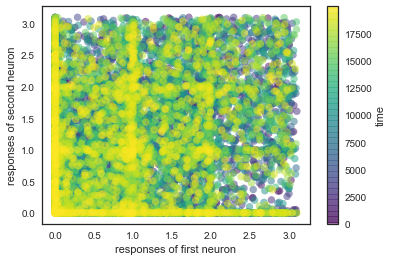

In [9]:
plt.scatter(resps[0], resps[4], c=np.arange(20000), cmap='viridis', alpha=0.5)
plt.xlabel('responses of first neuron')
plt.ylabel('responses of second neuron')

plt.colorbar(label='time')
plt.show()

# remake in 3d
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(resps[0], resps[4], resps[9], alpha=0.1, c=np.arange(20000), cmap='viridis')
# plt.show()

In [ ]:
# plots each neuron responses against other neuron
# diagonal just shows histogram of neuron
g = sns.pairplot(pd.DataFrame(resps.transpose()), plot_kws=dict(alpha=0.2))
g.fig.set_size_inches(9, 9)